In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf

## Load

In [3]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (X_test, y_test) = boston_housing.load_data()

In [4]:
print(train_data.shape)
print(X_test.shape)

print(train_targets[:10])
print(y_test[:10])

(404, 13)
(102, 13)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]
[ 7.2 18.8 19.  27.  22.2 24.5 31.2 22.9 20.5 23.2]


## Data Preprocessing

### Standardization

In [5]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data = ( train_data - mean ) / std

X_test = ( X_test - mean ) / std

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_targets,
                                                    test_size=0.2,
                                                    random_state=2045)

In [7]:
X_train.shape, X_valid.shape

((323, 13), (81, 13))

## Keras Modeling

### Model Define

In [11]:
from tensorflow.keras import models, layers

boston = models.Sequential(name='Regression')
# Hidden Layer
boston.add(layers.Dense(64, activation='relu', input_shape = (13,)))
boston.add(layers.Dense(64, activation='relu'))

# Output Layer : 회귀이므로 activation이 필요 없음
boston.add(layers.Dense(1))

In [12]:
boston.summary()

Model: "Regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


### Model Compile

In [13]:
boston.compile(optimizer='rmsprop', loss='mse',
               metrics=['mae'])

### Model Fit

In [14]:
%%time

Hist_boston = boston.fit(X_train, y_train, epochs=500, 
                         batch_size=1, validation_data=(X_valid, y_valid))

Epoch 1/500
323/323 [==============================] - 1s 2ms/step - loss: 221.3027 - mae: 11.0671 - val_loss: 59.5909 - val_mae: 4.9202
Epoch 2/500
323/323 [==============================] - 0s 1ms/step - loss: 33.4150 - mae: 4.0961 - val_loss: 32.6976 - val_mae: 3.3679
Epoch 3/500
323/323 [==============================] - 0s 1ms/step - loss: 22.6184 - mae: 3.3193 - val_loss: 24.7526 - val_mae: 2.9145
Epoch 4/500
323/323 [==============================] - 0s 1ms/step - loss: 18.2215 - mae: 2.8257 - val_loss: 25.0677 - val_mae: 2.9109
Epoch 5/500
323/323 [==============================] - 0s 1ms/step - loss: 16.8798 - mae: 2.6846 - val_loss: 24.2342 - val_mae: 2.6874
Epoch 6/500
323/323 [==============================] - 0s 1ms/step - loss: 14.7938 - mae: 2.4920 - val_loss: 24.2869 - val_mae: 2.5666
Epoch 7/500
323/323 [==============================] - 0s 1ms/step - loss: 14.2231 - mae: 2.4027 - val_loss: 22.0611 - val_mae: 2.6365
Epoch 8/500
323/323 [==============================] 

## Model Evaluate

In [15]:
test_mse_score, test_mae_score = boston.evaluate(X_test, y_test)

print('MSE :', test_mse_score)
print('MAE :', test_mae_score)

4/4 [==============================] - 0s 4ms/step - loss: 16.3587 - mae: 2.5553
MSE : 16.358747482299805
MAE : 2.555253505706787


### Visualization

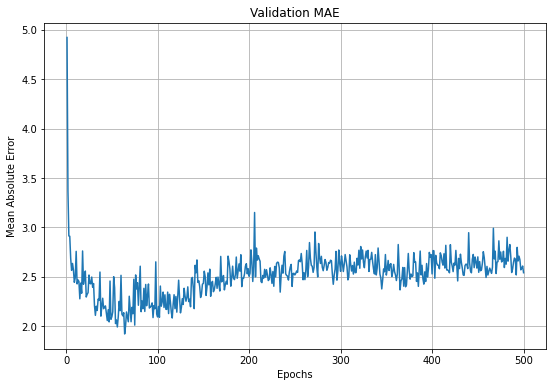

In [16]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_boston.history['val_mae'])+1)

plt.figure(figsize=(9, 6))
plt.plot(epochs, Hist_boston.history['val_mae'])
plt.title('Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.grid()
plt.show()

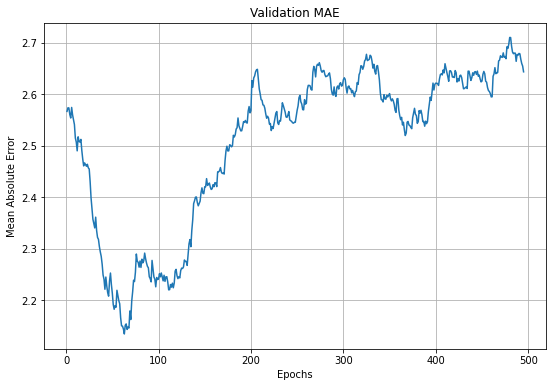

In [17]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

mae_history = Hist_boston.history['val_mae']
mae_history = smooth_curve(mae_history[5:])

plt.figure(figsize=(9, 6))
plt.plot(range(1, len(mae_history)+1), mae_history)
plt.title('Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.grid()
plt.show()

### Keras Session Clear

In [18]:
from tensorflow.keras import backend as K

K.clear_session()

## Early Stopping

### Model Define, Compile

In [19]:
from tensorflow.keras import models, layers

boston = models.Sequential(name='Regression')
# Hidden Layer
boston.add(layers.Dense(64, activation='relu', input_shape = (13,)))
boston.add(layers.Dense(64, activation='relu'))

# Output Layer : 회귀이므로 activation이 필요 없음
boston.add(layers.Dense(1))
boston.compile(optimizer='rmsprop', loss='mse',
               metrics=['mae'])

### Early Stopping
- monitor : 모니터링 대상 성능
- mode : 모니터링 대상을 최대/최소화
- patience : 성능이 개선되지 않는 epochs 횟수

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_mae',
                   mode='min',
                   patience=50,
                   verbose=1)

### ModelCheckpoint
- 'best_boston.h5' : 최적 모델이 저장될 경로
- save_best_only : 최적 모델만 저장할지 결정

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint('best_boston.h5',
                     monitor='val_mae',
                     mode='min',
                     save_best_only=True,
                     verbose=1)

### Model Fit with callbacks

In [22]:
%%time

Hist_boston = boston.fit(X_train, y_train, epochs=500, 
                         batch_size=1, validation_data=(X_valid, y_valid),
                         callbacks=[es, mc], verbose=1)

Epoch 1/500
323/323 [==============================] - 1s 2ms/step - loss: 180.0133 - mae: 9.7014 - val_loss: 54.1914 - val_mae: 4.1951

Epoch 00001: val_mae improved from inf to 4.19508, saving model to best_boston.h5
Epoch 2/500
323/323 [==============================] - 0s 1ms/step - loss: 27.1756 - mae: 3.5991 - val_loss: 34.0131 - val_mae: 3.1170

Epoch 00002: val_mae improved from 4.19508 to 3.11703, saving model to best_boston.h5
Epoch 3/500
323/323 [==============================] - 0s 1ms/step - loss: 19.8037 - mae: 3.0523 - val_loss: 25.4195 - val_mae: 2.6219

Epoch 00003: val_mae improved from 3.11703 to 2.62190, saving model to best_boston.h5
Epoch 4/500
323/323 [==============================] - 0s 1ms/step - loss: 16.5708 - mae: 2.7980 - val_loss: 24.7607 - val_mae: 2.9285

Epoch 00004: val_mae did not improve from 2.62190
Epoch 5/500
323/323 [==============================] - 0s 1ms/step - loss: 14.9191 - mae: 2.6134 - val_loss: 21.3252 - val_mae: 2.6695

Epoch 00005: va

### Best Model

In [23]:
!ls -l

total 76
-rw-r--r-- 1 root root 70280 Aug  5 08:44 best_boston.h5
drwxr-xr-x 1 root root  4096 Jul 16 13:20 sample_data


### Model Evaluate

In [24]:
test_mse_score, test_mae_score = boston.evaluate(X_test, y_test)

print('MSE :', test_mse_score)
print('MAE :', test_mae_score)

4/4 [==============================] - 0s 3ms/step - loss: 22.1042 - mae: 2.9860
MSE : 22.10419464111328
MAE : 2.9860222339630127


## 주의점
- 너무 빨리 끝나면 underfitting 가능성이 높아짐